In [66]:
import math

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from forecast.weather import (
    get_weather_data, 
    get_train_test_sets, 
    forecast_weather, 
    forecast_one_time_step,
    iterate_over_window,
    load_lstm_model,
)

sns.set(font_scale=1.5, palette='colorblind')

# Weather forecast

In [2]:
weather_data_path = '~/workspace/ds/data/AMPds/Climate_HourlyWeather.csv'
X, scaler = get_weather_data(weather_data_path)
X_train, X_test = get_train_test_sets(X)

In [3]:
X_train.shape, X_test.shape

((12230, 4), (5241, 4))

## Plot temperature prediction

In [4]:
X = np.concatenate((X_train, X_test))
predictions = forecast_weather(X, verbose=True)

In [5]:
predictions.shape

(17448, 4)

In [6]:
len(X_train) + len(X_test) + 24

17495

In [7]:
X_predictions = scaler.inverse_transform(predictions)
X_train_p = scaler.inverse_transform(X_train)
X_test_p = scaler.inverse_transform(X_test)

In [8]:
X_predictions.shape[0], X_train_p.shape[0] + X_test_p.shape[0]

(17448, 17471)

In [9]:
def plot_attribute(X_train, X_test, X_predictions, attr):
    attributes = ['Temp (C)', 'Dew Point Temp (C)', 'Visibility (km)', 'Stn Press (kPa)']
    attr_idx = attributes.index(attr)
    
    f, ax = plt.subplots(1, figsize=(20, 8))
    
    x = range(len(X_train) + len(X_test) + 1)
    train_trace = np.concatenate((X_train[:,attr_idx], [float('nan')] * (len(X_test) + 1)))
    test_trace = np.concatenate(([float('nan')] * len(X_train), X_test[:,attr_idx], [float('nan')]))
    forecast_trace = np.concatenate(([float('nan')] * 24, X_predictions[:,attr_idx]))
    
    ax.plot(x, train_trace, label='Train')
    ax.plot(x, test_trace, label='Test')
    ax.plot(x, forecast_trace, label='Forecast')
    
    ax.set_title(f'{attr} - Actual and Forecast')
    ax.legend()

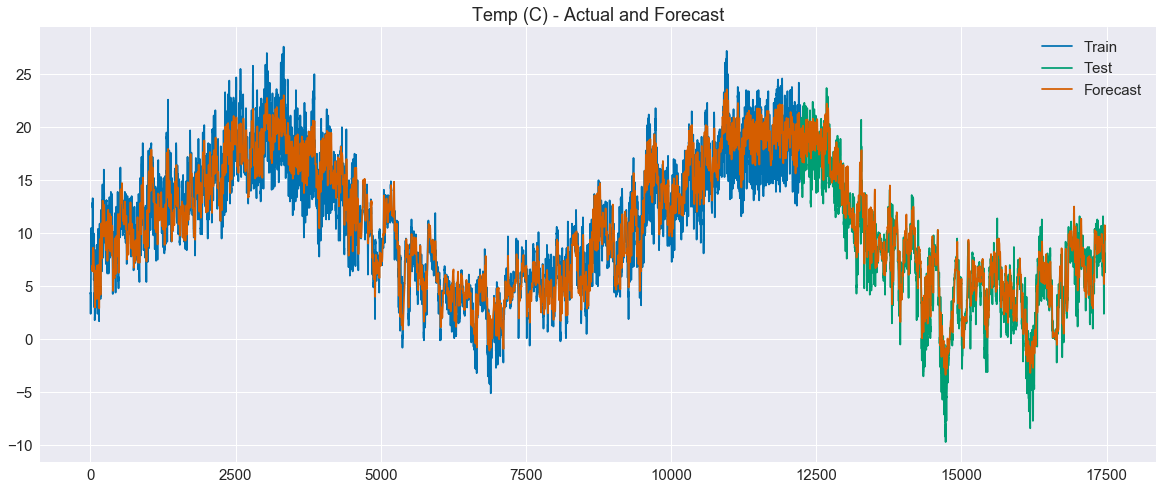

In [10]:
plot_attribute(X_train_p, X_test_p, X_predictions, 'Temp (C)')

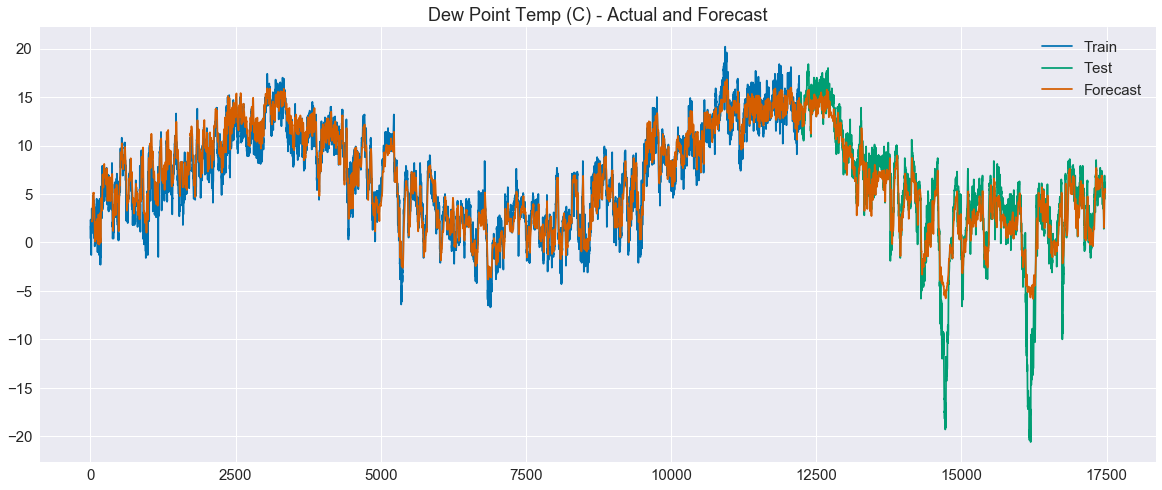

In [53]:
plot_attribute(X_train_p, X_test_p, X_predictions, 'Dew Point Temp (C)')

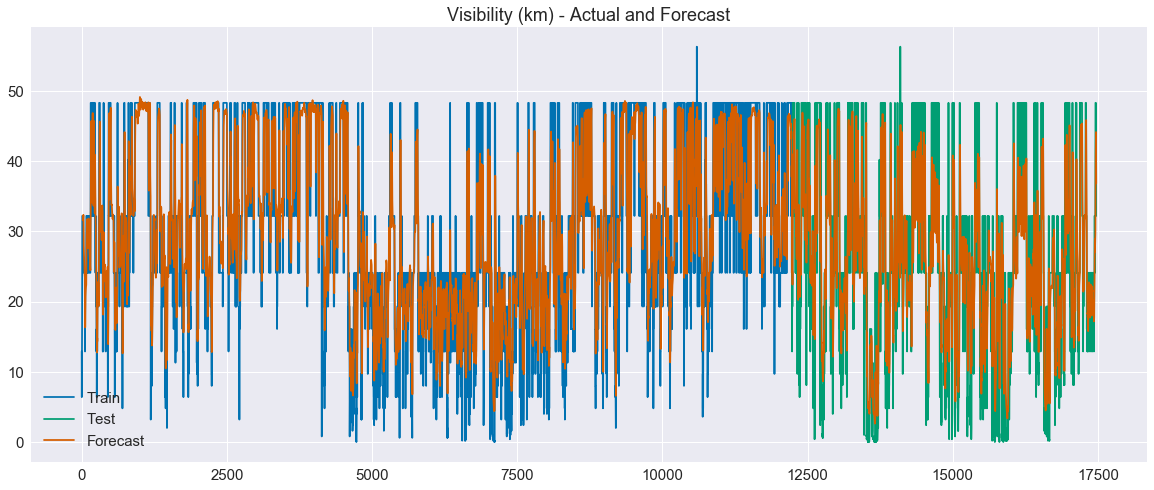

In [54]:
plot_attribute(X_train_p, X_test_p, X_predictions, 'Visibility (km)')

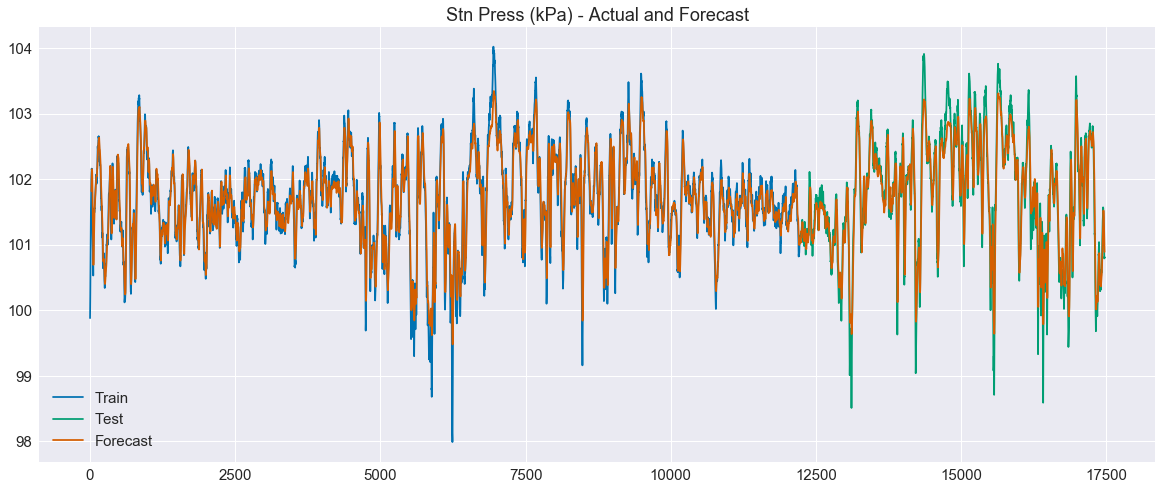

In [11]:
plot_attribute(X_train_p, X_test_p, X_predictions, 'Stn Press (kPa)')

In [56]:
def get_mean_absolute_errors(X_train, X_test, X_predictions):
    res = {}
    for i, attr in enumerate(['Temp (C)', 'Dew Point Temp (C)', 'Visibility (km)', 'Stn Press (kPa)']):
        train_trace = np.concatenate((X_train[:,i], [float('nan')] * (len(X_test) + 1)))
        test_trace = np.concatenate(([float('nan')] * len(X_train), X_test[:,i], [float('nan')]))
        forecast_trace = np.concatenate(([float('nan')] * 24, X_predictions[:,i]))
        
        error_train = np.abs(forecast_trace - train_trace)
        error_test = np.abs(forecast_trace - test_trace)
        res[attr] = {
            'train': np.mean([a for a in error_train if not math.isnan(a)]),
            'test': np.mean([a for a in error_test if not math.isnan(a)]),
        }
        
    return res

In [65]:
for attr, val in get_mean_absolute_errors(X_train_p, X_test_p, X_predictions).items():
    print(f"{attr} mean error:\n\t\t\t\ttrain: {round(val['train'], 2)}\ttest: {round(val['test'], 2)}")
    print()

Temp (C) mean error:
				train: 1.59	test: 1.39

Dew Point Temp (C) mean error:
				train: 1.16	test: 1.67

Visibility (km) mean error:
				train: 4.67	test: 5.83

Stn Press (kPa) mean error:
				train: 0.15	test: 0.19



## Generate forecasts for a few time steps

In [21]:
def forecast_going_foward(X, start_idx=0, num_forecasts=10, verbose=False):
    all_forecasts = []
    predictions = []
    with load_lstm_model() as lstm_model:
        x = None
        for i, x_actual in enumerate(iterate_over_window(X[start_idx:])):
            if i == 0:
                x = x_actual
                
            if i == num_forecasts:
                break
 
            if verbose and i % 1000 == 0:
                print(f'Iteration {i}')

            x_forecast = forecast_one_time_step(lstm_model, x)
            x = x_forecast
            
            predictions.append(x_forecast[-1])
            all_forecasts.append(x_forecast)
            
    return predictions, all_forecasts

In [41]:
predictions, all_forecasts = forecast_going_foward(X, start_idx=0, num_forecasts=48)

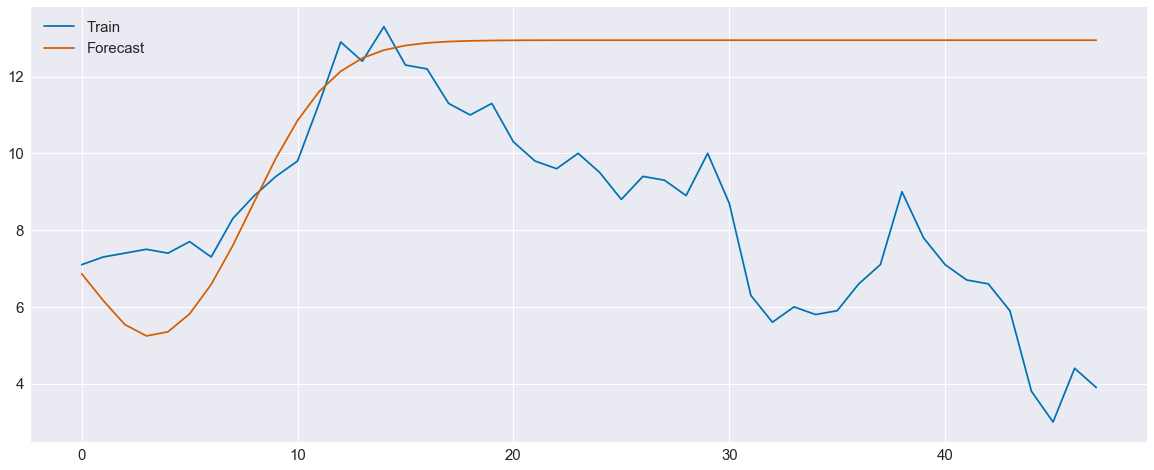

In [43]:
preds = scaler.inverse_transform(predictions)
X__ = scaler.inverse_transform(X_train[25:25+48])

f, ax = plt.subplots(1, figsize=(20, 8))
    
x = range(len(X__))

ax.plot(x, X__[:,0], label='Train')
ax.plot(x, preds[:,0], label='Forecast', color=(0.8352941176470589, 0.3686274509803922, 0.0))

ax.legend()